Task : Implement an econometric model for predicting gold price evolution
explain models of choice and final forcasts

In [1]:
import itertools
import numpy as np
import pyflux as pf
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from pandas import DataFrame
import datetime
import quandl
%matplotlib inline
%config InlineBackend.figure_formats=['png']

In [2]:
start = datetime.datetime(1975, 1, 1)
end = datetime.datetime(2017, 1, 27)

##data source quandl = gold priced in USD
data = quandl.get("BUNDESBANK/BBK01_WT5511", authtoken="LSQt2S1x-abvHTx_Lavx")

In [3]:
data.tail()

,Value
Date,
2016-04-12,1259.20
2016-04-13,1245.75
2016-04-14,1240.30
2016-04-15,1229.75
2016-04-18,1237.70


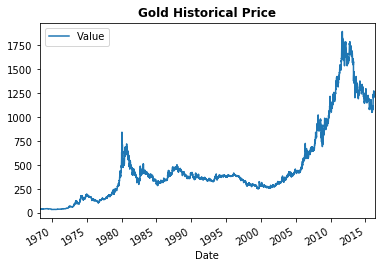

In [4]:
data.plot(y="Value")
plt.title(u"Gold Historical Price", weight='bold');

VAR - Value At Risk Model

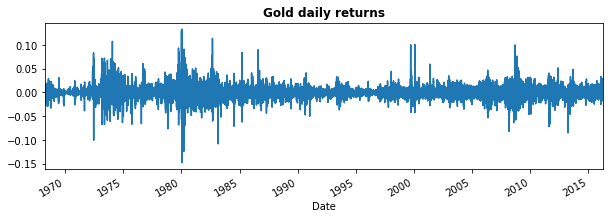

In [5]:
fig = plt.figure()
fig.set_size_inches(10,3)
data["Value"].pct_change().plot()
plt.title(u"Gold daily returns", weight='bold');

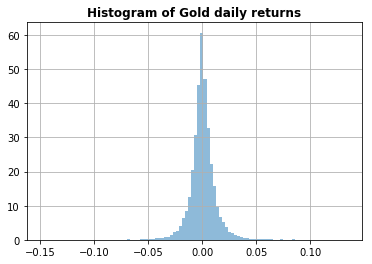

In [6]:
data["Value"].pct_change().hist(bins=100, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of Gold daily returns", weight='bold')

In [7]:
data["Value"].pct_change().std()

0.012800532647021069

Let's see whether the daily returns are better represented by a normal distribution or by a Student-t distribution

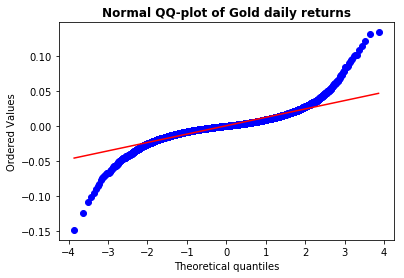

In [8]:
g = data["Value"].pct_change().dropna().as_matrix()
scipy.stats.probplot(g, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Gold daily returns", weight="bold");

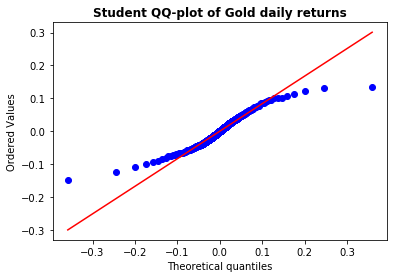

In [9]:
tdf, tmean, tsigma = scipy.stats.t.fit(g)
scipy.stats.probplot(g, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Gold daily returns", weight="bold");

Var Using Historical Bootstrap Method
Calculate empirical quantiles from histogram of daily returns

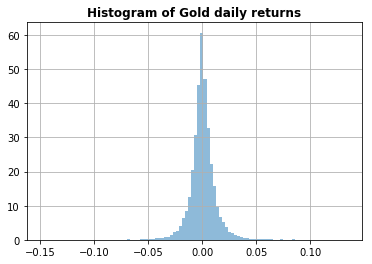

In [10]:
mean = data["Value"].pct_change().mean()
sigma = data["Value"].pct_change().std()
data["Value"].pct_change().hist(bins=100, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of Gold daily returns", weight='bold')

In [11]:
data["Value"].pct_change().quantile(0.05)

-0.017658176728977515

The 0.05 empirical quantile of daily returns is at -0.017. That means that with 95% confidence, our worst daily loss will not exceed 3.4%.

VAR at Risk Using the Variance-Covariance Method

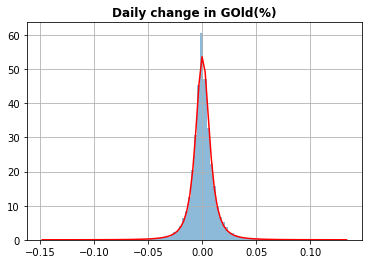

In [12]:
import numpy as np
support = np.linspace(data["Value"].pct_change().min(), data["Value"].pct_change().max(), 100)
data["Value"].pct_change().hist(bins=100, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in GOld(%)", weight='bold');

In [13]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.020686542521542159

Our analytic 0.05 quantile is at -0.0206, so with 95% confidence, our worst daily loss will not exceed 2.06%

ARIMA Model 

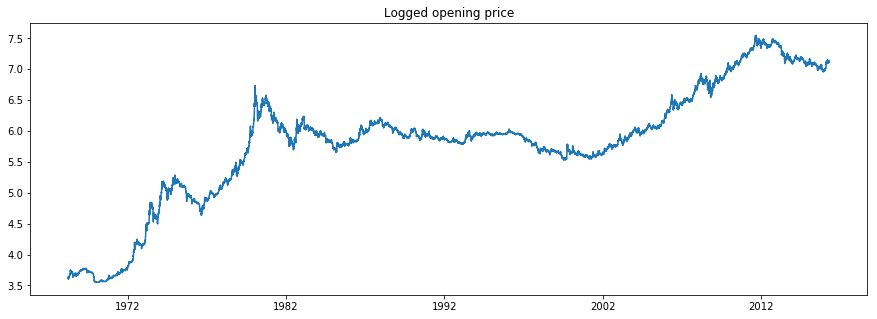

In [18]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import pyflux as pf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
start = datetime.datetime(2004, 11, 22)
end = datetime.datetime(2017, 1, 27)

##data source quandl = gold priced in USD
#gld = data.DataReader(['GLD'],  'google', start, end)


##data source quandl = gold priced in USD
gld = quandl.get("BUNDESBANK/BBK01_WT5511", authtoken="LSQt2S1x-abvHTx_Lavx",index_col=['Date','Value'])
#gld.index = gld['Date','Value'].values

opening_prices = np.log(gld['Value'])
plt.figure(figsize=(15,5));
plt.plot(opening_prices.index,opening_prices);
#plt.legend(opening_prices.columns.values,loc=3);
plt.title("Logged opening price");


VAR specifications and see which one minimizes the AIC. Here we just opt for VAR(2) model, which we fit via OLS:

In [19]:
gld.head()

,Value
Date,
1968-04-01,38.0
1968-04-02,37.6
1968-04-03,37.7
1968-04-04,36.7
1968-04-05,37.2


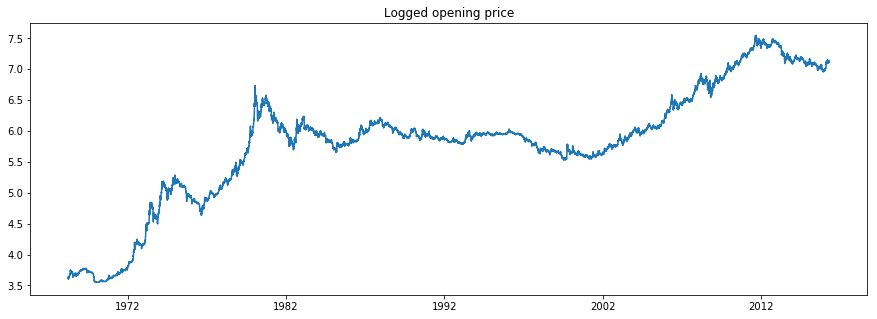

In [20]:
op = np.log(gld['Value'])
plt.figure(figsize=(15,5));
plt.plot(opening_prices.index,opening_prices);
#plt.legend(opening_prices.columns.values,loc=3);
plt.title("Logged opening price");

In [21]:
op.tail()

Date
2016-04-12    7.138232
2016-04-13    7.127493
2016-04-14    7.123109
2016-04-15    7.114566
2016-04-18    7.121010
Name: Value, dtype: float64

In [22]:
op = pd.DataFrame(op)
op.tail()

,Value
Date,
2016-04-12,7.138232
2016-04-13,7.127493
2016-04-14,7.123109
2016-04-15,7.114566
2016-04-18,7.121010


In [23]:
model = pf.ARIMA(data=op,ar=4,ma=4,integ=0,target='Value')

In [24]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: Value                               Method: MLE                                       
Start Date: 1968-04-05 00:00:00                         Log Likelihood: -911.3265                         
End Date: 2016-04-18 00:00:00                           AIC: 1842.6531                                    
Number of observations: 12148                           BIC: 1916.7023                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 5.6331     0.0727     77.4581  0.0      (5.4906 | 5.7757)        
AR(1)                                

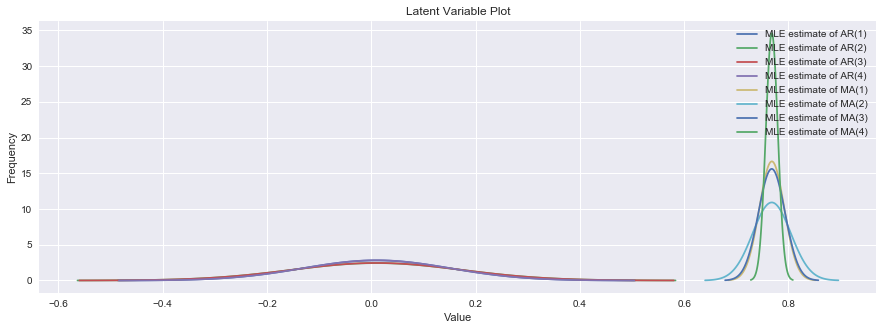

In [25]:
model.plot_z(indices=range(1,9))

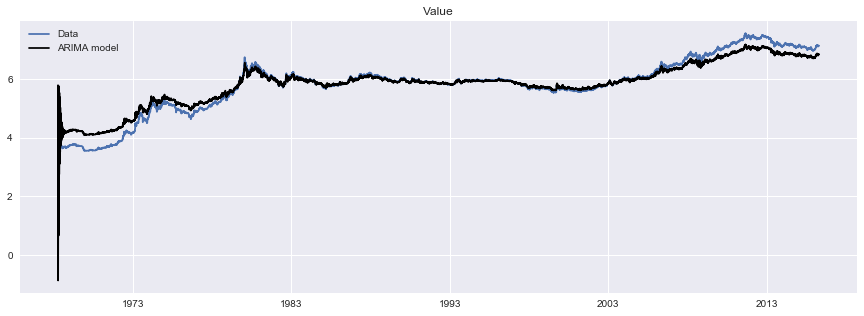

In [26]:
model.plot_fit(figsize=(15,5))

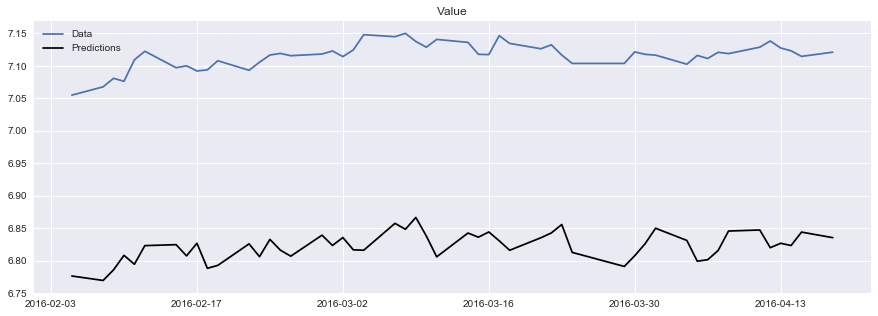

In [27]:
model.plot_predict_is(50,figsize=(15,5))

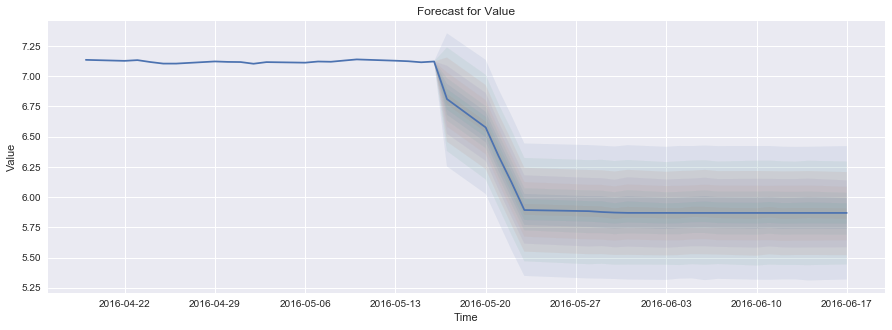

In [28]:
model.plot_predict(h=20,past_values=20,figsize=(15,5))

In [29]:
model.predict(h=20)

,Value
Date,
2016-05-17,6.810342
2016-05-20,6.575834
2016-05-21,6.339517
2016-05-22,6.122811
2016-05-23,5.892879
2016-05-28,5.883661
2016-05-29,5.876694
2016-05-30,5.872022
2016-05-31,5.869478


GARCH Model

In [30]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import pyflux as pf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
start = datetime.datetime(2004, 11, 22)
end = datetime.datetime(2017, 1, 27)

##data source quandl = gold priced in USD
#gld = data.DataReader(['GLD'],  'google', start, end)


##data source quandl = gold priced in USD
gold = quandl.get("BUNDESBANK/BBK01_WT5511", authtoken="LSQt2S1x-abvHTx_Lavx",index_col=['Date','Value'])
#gld.index = gld['Date','Value'].values

In [31]:
gc = pd.DataFrame(gold)
gc.tail()

,Value
Date,
2016-04-12,1259.20
2016-04-13,1245.75
2016-04-14,1240.30
2016-04-15,1229.75
2016-04-18,1237.70


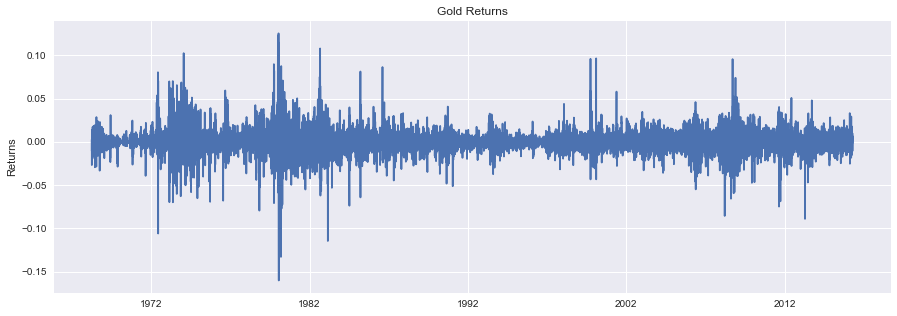

In [32]:
returns = pd.DataFrame(np.diff(np.log(gc['Value'].values)))
returns.index = gc.index.values[1:gc.index.values.shape[0]]
returns.columns = ['GOLD Returns']

plt.figure(figsize=(15,5));
plt.plot(returns.index,returns);
plt.ylabel('Returns');
plt.title('Gold Returns');

One way to visualize the underlying volatility of the series is to plot the absolute returns \mid{y}\mid:

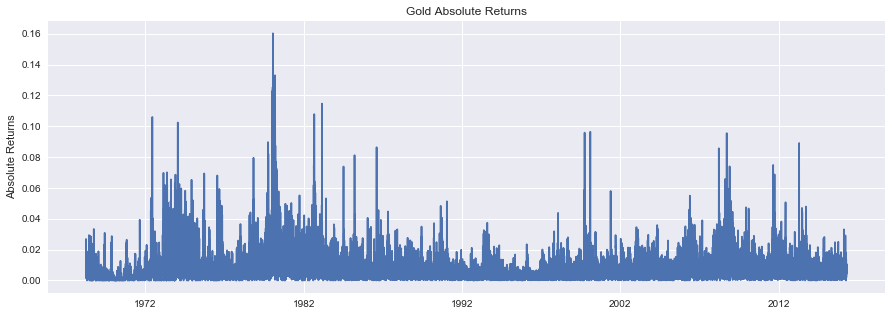

In [33]:
plt.figure(figsize=(15,5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel('Absolute Returns')
plt.title('Gold Absolute Returns');

There appears to be some evidence of volatility clustering over this period. Let’s fit a GARCH(1,1) model using a point mass estimate

In [34]:
model = pf.GARCH(returns,p=1,q=1)
x = model.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: GOLD Returns                        Method: MLE                                       
Start Date: 1968-04-03 00:00:00                         Log Likelihood: 38772.7827                        
End Date: 2016-04-18 00:00:00                           AIC: -77537.5653                                  
Number of observations: 12150                           BIC: -77507.945                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

plot the GARCH parameters with plot_z

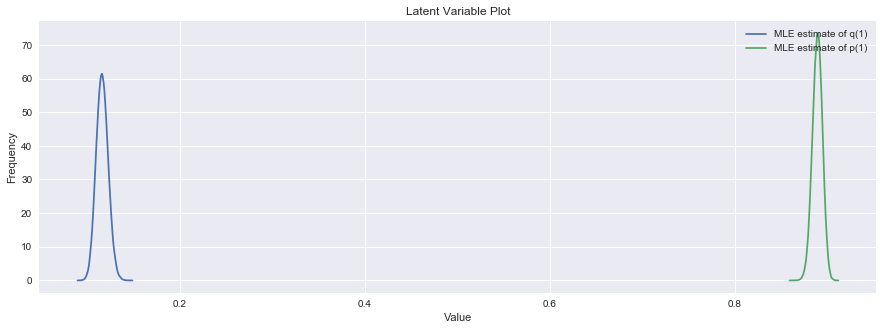

In [35]:
model.plot_z([1,2],figsize=(15,5))

 plot the fit with plot_fit:

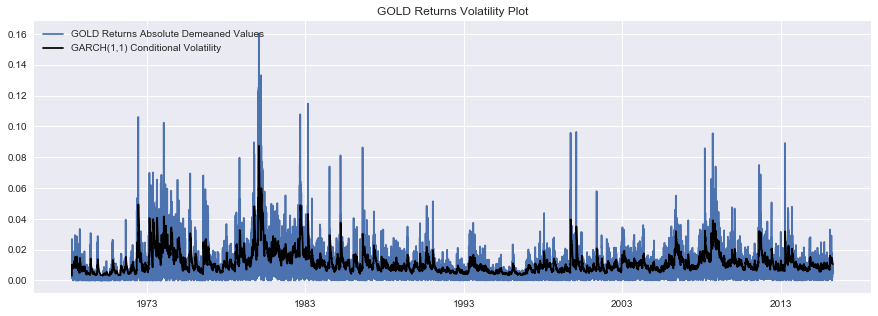

In [36]:
model.plot_fit(figsize=(15,5))

In [ ]:
model.predict(h=10)

,GOLD Returns
2016-05-05,0.000107
2016-05-06,0.000114
2016-05-07,0.000122
2016-05-08,0.000128
2016-05-11,0.000134
2016-05-12,0.000139
2016-05-13,0.000145
2016-05-14,0.000149
2016-05-15,0.000153
2016-05-18,0.000155


how well we predicted using dynamic in-sample rolling prediction with plot_predict_is

In [ ]:
model.plot_predict_is(h=50,figsize=(15,5))

Vector Error Correction